In [1]:
!pip install ruclip -q
!pip install -U huggingface_hub -q
!pip install sentence-transformers -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 2.19.2 requires huggingface-hub>=0.21.2, but you have huggingface-hub 0.2.1 which is incompatible.
tokenizers 0.19.1 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 0.2.1 which is incompatible.
transformers 4.41.2 requires huggingface-hub<1.0,>=0.23.0, but you have huggingface-hub 0.2.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ruclip 0.0.2 requires huggingface-hub==0.2.1, but you have huggingface-hub 0.23.3 which is incompatible.


In [2]:
import multiprocessing
import torch
from psutil import virtual_memory

ram_gb = round(virtual_memory().total / 1024**3, 1)

print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device.type)

!nvidia-smi

CPU: 4
RAM GB: 31.4
PyTorch version: 2.1.2
CUDA version: 12.1
cuDNN version: 8900
device: cuda
Thu Jun  6 11:24:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              26W / 250W |      2MiB / 16384MiB |      0%      Default |
|                                         |                    

In [3]:
import glob
import os
import pandas as pd
import numpy as np
import json
import math
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import random
import collections

from datetime import date, timedelta

from PIL import Image
import ruclip
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm

# import torch
from torch import nn, optim
from torchvision import transforms
import torchtext
from torch.utils.data import Dataset, DataLoader, BatchSampler
from transformers import get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
import nltk, re, string, collections
from nltk.util import ngrams
%matplotlib inline

2024-06-06 11:24:24.451214: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 11:24:24.451349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 11:24:24.575071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
!python --version

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Python 3.10.13


In [5]:
# PARAMS:
BATCH_SIZE = 512
EPOCH = 7
LR = 1e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2
NUM_WARMUP_STEPS = 0

FREEZE_IMAGE_ENCODER = True
FREEZE_TEXT_ENCODER = False
IMG_SIZE = (224, 368)
NAME_TO_SAVE = 'clip_finetune_vision_frozen'

In [6]:
model, processor = ruclip.load('ruclip-vit-base-patch16-384', device=device) # ruclip-vit-large-patch14-336

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:671: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


bpe.model:   0%|          | 0.00/748k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/600M [00:00<?, ?B/s]

In [11]:
# model = nn.DataParallel(model)
captions_path = '/kaggle/input/indeepa-images/images_urls_names.csv'

In [7]:
images_urls_names = pd.read_csv()
images_urls_names.set_index('NmId', inplace=True)
images_urls_names.rename(columns={'name':'caption'}, inplace=True)

images_path = '/kaggle/input/indeepa-images/'
d_train, d_test = {}, {}
with os.scandir(images_path + 'train') as it:
    for entry in it:
        if entry.is_file():
            sku = int(entry.name[:-4])
            caption = images_urls_names.loc[sku].caption
            img_path = entry.path
            d_train.update({img_path:caption})
            
with os.scandir(images_path + 'test') as it: # TODO: cut for finetuning
    for entry in it:
        if entry.is_file():
            sku = int(entry.name[:-4]) 
            caption = images_urls_names.loc[sku].caption
            img_path = entry.path
            d_test.update({img_path:caption}) # TODO: d_train insted of d_test now, change for futher checking
            
# check for broken images:
errors = list()
for path in d_train:
    try:
        Image.open(path)
    except:
        l = path.rfind('/')
        errors.append(int(path[l+1:-4]))
print(errors)

[]


In [8]:
class RuCLIPDataset(Dataset):
    def __init__(self, captions_path, img_dir, processor) -> None:
        self.processor = processor
        self.df = pd.read_csv(captions_path)
        self.df.rename(columns={'name':'caption', 
                                      'ImageLink':'url', 
                                      'NmId':'sku'}, inplace=True)
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img_name = str(self.df['sku'].iloc[idx]) + '.jpg'
        cap = self.df['caption'].iloc[idx]
        img = Image.open(os.path.join(self.img_dir, img_name))
        res = self.processor(cap, [img], image_size=IMG_SIZE)
        return res['input_ids'].squeeze(), res['pixel_values'].squeeze()
    
train_dataset = RuCLIPDataset(d_train, processor)
test_dataset = RuCLIPDataset(d_test, processor)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
len(train_dataset), train_dataset[0] 

(6404,
 (tensor([   2, 5613, 9362,    3,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0]),
  tensor([[[ 1.3610,  1.3756,  1.4048,  ...,  1.3464,  0.3391, -0.4784],
           [ 1.3756,  1.3902,  1.4194,  ...,  1.4924,  0.3975, -0.5076],
           [ 1.3902,  1.4048,  1.4486,  ...,  1.6676,  0.4997, -0.4930],
           ...,
           [ 1.2734,  1.2880,  1.3026,  ...,  1.4486,  1.4486,  1.4486],
           [ 1.2588,  1.2734,  1.2880,  ...,  1.4486,  1.4632,  1.4632],
           [ 1.2296,  1.2442,  1.2588,  ...,  1.4486,  1.4632,  1.4778]],
  
 

In [33]:
# class TextCLIP(nn.Module):
#     def __init__(self, model) :
#         super(TextCLIP, self).__init__()
#         self.model = model
        
#     def forward(self,text):
#         return self.model.encode_text(text)
    
# class ImageCLIP(nn.Module):
#     def __init__(self, model) :
#         super(ImageCLIP, self).__init__()
#         self.model = model
        
#     def forward(self,image):
#         return self.model.encode_image(image)
    
# model_text = TextCLIP(model)
# model_image = ImageCLIP(model)

# model_text = nn.DataParallel(model_text)
# model_image = nn.DataParallel(model_image)

# optimizer = optim.Adam(model.parameters(), lr=5e-6,betas=(0.9,0.98),eps=1e-6,weight_decay=0.05)

In [ ]:
# for texts, images in train_dataloader:
#     texts, images = texts.to(device), images.to(device)
    
#     text_embedding = model_text(texts)
#     image_embedding = model_image(images)
#     print("Text emb size", text_embedding.size())
#     break

In [24]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()
# with torch.no_grad():
#     torch.cuda.empty_cache()

In [9]:
for batch in train_dataloader:
    txt, img = batch
    print(img.shape)
    print(txt.shape)
    break

torch.Size([256, 3, 384, 384])
torch.Size([256, 77])


In [51]:
# freeze text encoder
for i, child in enumerate(model.children()):
    if (i == 0 and FREEZE_IMAGE_ENCODER) or (i == 1 and FREEZE_TEXT_ENCODER):
        for param in child.parameters():
            param.requires_grad = False

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-8,
                                          weight_decay=WEIGHT_DECAY)
TOTAL_STEPS = len(train_dataloader) * EPOCH
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=NUM_WARMUP_STEPS, num_training_steps=TOTAL_STEPS)

# optimizer = optim.Adam(model.parameters(), lr=5e-5,betas=(0.9,0.98),eps=1e-6,WEIGHT_DECAY=0.2)
# optimizer = optim.Adam(model.parameters(), lr=1e-5)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_dataloader)*EPOCH)

In [ ]:
class Trainer:
    def __init__(self, train_dataframe, train_dir,
                 val_dataframe=None, val_dir=None, learning_rate=1e-4,
                 freeze_image_encoder=True, freeze_text_encoder=False, max_text_len=77,
                 train_batch_size=64, val_batch_size=64, num_workers=2,
                 weight_decay=1e-4, grad_accum=8):
        
        self.train_dataframe = train_dataframe
        self.train_dir = train_dir
        self.val_dataframe = val_dataframe
        self.val_dir = val_dir
        self.learning_rate = learning_rate
        self.freeze_image_encoder = freeze_image_encoder
        self.freeze_text_encoder = freeze_text_encoder
        self.max_text_len = max_text_len
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.num_workers = num_workers
        self.weight_decay = weight_decay
        self.grad_accum = grad_accum
        print(f"train batch size = {self.train_batch_size * self.grad_accum}")

    def train_model(self, model, epochs_num=1, device='cuda', verbose=10):

        is_val = self.val_dataframe is not None and self.val_dir is not None

        model.to(device)

        train_dataset = RuCLIPDataset(self.train_dir, self.train_dataframe, self.max_text_len)

        train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                    batch_size=self.train_batch_size,
                                                    shuffle=True,
                                                    pin_memory=True,
                                                    num_workers=self.num_workers)

        if is_val:
            val_dataset = RuCLIPDataset(self.val_dir, self.val_dataframe, self.max_text_len)
            val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                                     batch_size=self.val_batch_size,
                                                     shuffle=False,
                                                     pin_memory=True,
                                                     num_workers=self.num_workers)

        for i, child in enumerate(model.children()):
            if (i == 0 and self.freeze_image_encoder) or (i == 1 and self.freeze_text_encoder):
                for param in child.parameters():
                    param.requires_grad = False

        loss_img = torch.nn.CrossEntropyLoss()
        loss_txt = torch.nn.CrossEntropyLoss()

        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, betas=(0.9, 0.98), eps=1e-8,
                                          weight_decay=self.weight_decay)
        total_steps = len(train_loader) * epochs_num
        scheduler = get_linear_schedule_with_warmup(optimizer,
                                                        num_warmup_steps=0,
                                                        num_training_steps=total_steps)
        for epoch in range(epochs_num):
            model.train()
            print(f'start training epoch {epoch}')
            curr_batch = 0
            X = []
            Y = []
            curr_batch = 0
            for i, batch in enumerate(tqdm(train_loader)):
                images = batch[0].cuda()
                input_ids = batch[1].cuda()
                # attention_mask = batch[2].cuda()

                image_features = model.encode_image(images)
                text_features = model.encode_text(input_ids)

                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)

                X.append(image_features)
                Y.append(text_features)

                if ((i + 1) % self.grad_accum == 0) or (i + 1 == len(train_loader)):
                    optimizer.zero_grad()
                    X = torch.cat(X, axis=0).cuda()
                    Y = torch.cat(Y, axis=0).cuda()
                    logit_scale = model.logit_scale.exp()
                    logits_per_image = logit_scale * X @ Y.t()
                    logits_per_text = logits_per_image.t()
                    ground_truth = torch.arange(X.shape[0], dtype=torch.long).cuda()
                    img_l = loss_img(logits_per_image, ground_truth)
                    text_l = loss_txt(logits_per_text, ground_truth)
                    total_loss = (img_l + text_l) / 2
                    if curr_batch % verbose == 0:
                        print(f'{i}/{len(train_loader)} total_loss {total_loss}')
                    total_loss.backward()   
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
                    optimizer.step()
                    scheduler.step()
                    
                    X = []
                    Y = []
                    curr_batch += 1
            if is_val:
                print(f'start val epoch {epoch}')
                total_loss = 0
                model.eval()
                with torch.no_grad():
                    for i, batch in enumerate(tqdm(val_loader)):
                        images = batch[0].to(device)
                        input_ids = batch[1].to(device)
                        attention_mask = batch[2].to(device)

                        logits_per_image, logits_per_text = model(images, input_ids, attention_mask)
                        ground_truth = torch.arange(batch[1].shape[0], dtype=torch.long).to(device)
                        img_l = loss_img(logits_per_image, ground_truth).item()
                        text_l = loss_txt(logits_per_text, ground_truth).item()
                        total_loss += (img_l + text_l) / 2
                    print(f'val loss = {total_loss / len(val_loader)}')
        return model

In [ ]:
trainer = Trainer(train_dataframe='/content/train.csv', train_dir='/content/flickr30k_images/flickr30k_images',
                  val_dataframe='/content/val.csv', val_dir='/content/flickr30k_images/flickr30k_images',
                  train_batch_size=64, grad_accum=16)

In [ ]:
model = trainer.train_model(model, epochs_num=1, device=device, verbose=2)

In [24]:
best_te_loss = 1e5
best_ep = -1
for epoch in tqdm(range(EPOCH)):
    print(f"running epoch {epoch}, best test loss {best_te_loss} after epoch {best_ep}")
    step = 0
    tr_loss = 0
    model.train()
    pbar = tqdm(train_dataloader, leave=False)
    for batch in pbar:
        step += 1
        optimizer.zero_grad()

        texts, images = batch
        texts = texts.to(device)
        images = images.to(device)
        with torch.autocast(device_type='cuda'):
            logits_per_image, logits_per_text = model(texts, images)
            ground_truth = torch.arange(BATCH_SIZE).to(device)
            img_loss = loss_img(logits_per_image,ground_truth)
            txt_loss = loss_txt(logits_per_text,ground_truth)
            total_loss = (img_loss + txt_loss)/2
        total_loss.backward()
        tr_loss += total_loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        pbar.set_description(f"train batchCE: {total_loss.item()}", refresh=True)
    tr_loss /= step
    
    step = 0
    te_loss = 0
    with torch.no_grad():
        model.eval()
        test_pbar = tqdm(test_dataloader, leave=False)
        for batch in test_pbar:
            step += 1
            texts, images = batch
            images = images.to(device)
            texts = texts.to(device)
            logits_per_image, logits_per_text = model(texts, images)
            ground_truth = torch.arange(BATCH_SIZE).to(device)
            img_loss = loss_img(logits_per_image,ground_truth)
            txt_loss = loss_txt(logits_per_text,ground_truth)
            total_loss = (img_loss + txt_loss)/2
            te_loss += total_loss.item()
            test_pbar.set_description(f"test batchCE: {total_loss.item()}", refresh=True)
        te_loss /= step
        
    if te_loss < best_te_loss:
        best_te_loss = te_loss
        best_ep = epoch
        torch.save(model.state_dict(), NAME_TO_SAVE + ".pt")
    print(f"epoch {epoch}, tr_loss {tr_loss}, te_loss {te_loss}")
# torch.save(model.state_dict(), NAME_TO_SAVE + ".pt")

  0%|          | 0/7 [00:00<?, ?it/s]

running epoch 0, best test loss 100000.0 after epoch -1



  0%|          | 0/7 [00:11<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py", line 185, in forward
    outputs = self.parallel_apply(replicas, inputs, module_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py", line 200, in parallel_apply
    return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replicas)])
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 110, in parallel_apply
    output.reraise()
  File "/opt/conda/lib/python3.10/site-packages/torch/_utils.py", line 694, in reraise
    raise exception
RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py", line 185, in forward
    outputs = self.parallel_apply(replicas, inputs, module_kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/data_parallel.py", line 200, in parallel_apply
    return parallel_apply(replicas, inputs, kwargs, self.device_ids[:len(replicas)])
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 110, in parallel_apply
    output.reraise()
  File "/opt/conda/lib/python3.10/site-packages/torch/_utils.py", line 694, in reraise
    raise exception
RuntimeError: Caught RuntimeError in replica 1 on device 1.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py", line 85, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/ruclip/model.py", line 207, in forward
    image_features = self.encode_image(pixel_values)
  File "/opt/conda/lib/python3.10/site-packages/ruclip/model.py", line 183, in encode_image
    return self.visual(pixel_values.type(self.dtype))
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/ruclip/model.py", line 78, in forward
    x = self.conv1(x)  # shape = [*, width, grid, grid]
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 460, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py", line 456, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:1 and cuda:0! (when checking argument for argument weight in method wrapper_CUDA__cudnn_convolution)




In [ ]:
# PATH = '/kaggle/input/indeepa-images/best_model.pt'
# PATH = '/kaggle/working/best_model_vision_not_frozen.pt'
# model.load_state_dict(torch.load(PATH))
# model.eval()

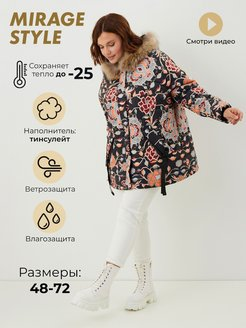

In [7]:
images = []
images.append(Image.open('/kaggle/input/indeepa-images/test/10116753.jpg'))
Image.open('/kaggle/input/indeepa-images/test/10116753.jpg')

# Делаем словарь sku:imgpath для того, чтобы удобно было загружать картинки

In [25]:
path = '/kaggle/input/data-from-mpstats-irina/new/data_scores.csv'
sku_names = pd.read_csv(path)[['sku_first', 'sku_second', 'name_first', 'name_second']]
images_urls_names = pd.read_csv('/kaggle/input/indeepa-images/images_urls_names.csv')
indeepa_images = set(images_urls_names.NmId.unique())

In [15]:
unique_labeled_skus = set(sku_names.sku_first.unique()).union(set(sku_names.sku_second.unique()))
unique_labeled_skus.intersection(indeepa_images)

set()

In [27]:
path = '/kaggle/input/indeepa-images/'
sku_to_imgpath = {}
# with os.scandir(path + 'train') as it:
#     for entry in it:
#         if entry.is_file():
#             sku_to_imgpath.update({int(entry.name[:-4]):entry.path})
            
# with os.scandir(path + 'test') as it: # TODO: cut for finetuning
#     for entry in it:
#         if entry.is_file():
#             sku_to_imgpath.update({int(entry.name[:-4]):entry.path})
            
with os.scandir(path + 'images_labeled') as it:
    for entry in it:
        if entry.is_file():
            sku_to_imgpath.update({int(entry.name[:-4]):entry.path})

In [8]:
# all = pd.read_csv('/kaggle/input/data-from-mpstats-irina/all.csv')
# sku_names = all[['sku_first', 'sku_second', 'name_first', 'name_second']]
# sku_names.to_csv('sku_names.csv', index=False)
# sku_names.sample(frac=1).reset_index(drop=True)

In [17]:
sku_to_imgpath[165606782]

'/kaggle/input/indeepa-images/images_labeled/165606782.jpg'

In [28]:
def cos_sim(a, b):
    return np.dot(a, b) / np.linalg.norm(a) / np.linalg.norm(b)

In [29]:
# prepare classes
names = list()
images = list()
for row in sku_names.iterrows():
    row = row[1]
    imgpath1, imgpath2 = sku_to_imgpath[row.sku_first], sku_to_imgpath[row.sku_second]
    name1, name2 = row.name_first, row.name_second
    names.append(name1)
    names.append(name2)
    images.append(Image.open(imgpath1))
    images.append(Image.open(imgpath2))

In [31]:
# fine-tuned
# device = 'cuda'
# clip, processor = ruclip.load('ruclip-vit-base-patch32-384', device=device)

classes = list(names)

templates = ['{}', 'это {}', 'на картинке {}', 'товар {}']

# predict
predictor = ruclip.Predictor(model, processor, device, bs=8, templates=templates)
with torch.no_grad():
    text_latents = predictor.get_text_latents(classes)
    # pred_labels = predictor.run(images, text_latents)
    images_latents = predictor.get_image_latents(images)

2688it [00:30, 87.19it/s]

2688it [00:15, 178.48it/s]


In [32]:
text_sims = []
image_sims = []
for ind in range(0, text_latents.shape[0], 2):
    first = text_latents[ind].cpu()
    second = text_latents[ind + 1].cpu()
    text_sims.append(cos_sim(first, second))
    
    first = images_latents[ind].cpu()
    second = images_latents[ind + 1].cpu()
    image_sims.append(cos_sim(first, second))

([0.95013994, 0.9082392, 0.92910737, 0.9483357, 0.86245126],
 [0.726479, 0.8234738, 0.7766202, 0.8323463, 0.5989367])

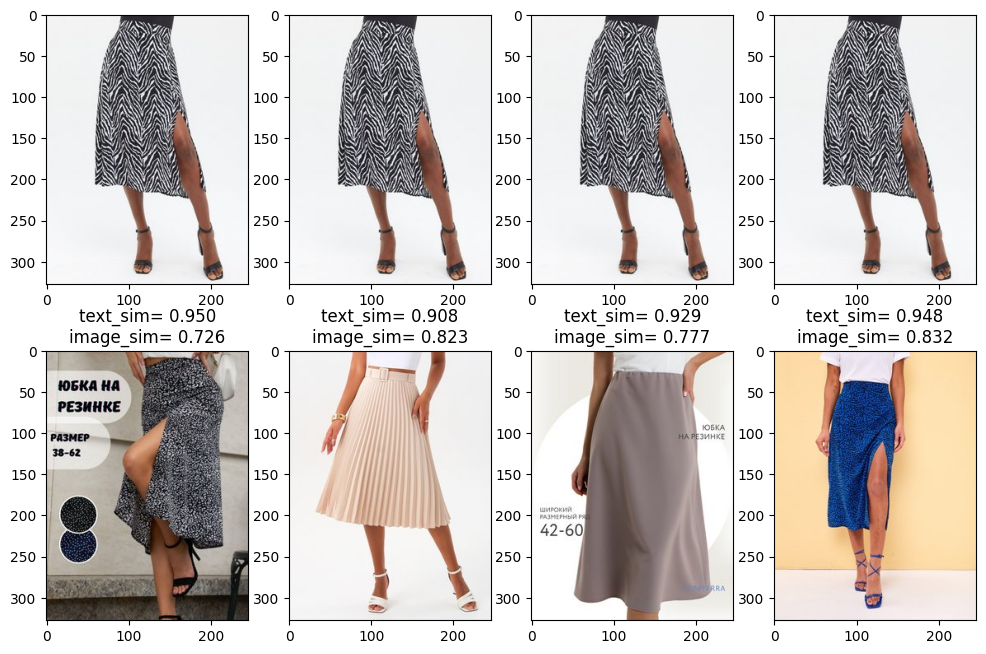

In [33]:
_, ax = plt.subplots(2,4, figsize=(12,8))
for i in range(4):
    ax[0, i%4].imshow(images[2*i])
    ax[1, i%4].imshow(images[2*i+1])
    ax[1, i%4].set_title(f'text_sim= {text_sims[i]:.3f}\nimage_sim= {image_sims[i]:.3f}')
text_sims[:5], image_sims[:5]

In [34]:
sims = pd.DataFrame(np.array([text_sims, image_sims]).T, columns = ['text_sim', 'img_sim'])
sims = pd.concat([sku_names[['sku_first', 'sku_second']], sims], axis=1)

In [35]:
 sims.to_csv('clip_sims_finetuned_vision.csv', index=False)